In [1]:
import numpy as np
import pylab
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import ExactEigensolver, VQE
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

In [2]:
# Note: In order to allow this to run reasonably quickly it takes advantage
#       of the ability to freeze core orbitals and remove unoccupied virtual
#       orbitals to reduce the size of the problem.

# tested molecular, LiH
molecule = 'Li .0 .0 -{0}; H .0 .0 {0}'

In [7]:
# choose 'ExactEigensolver' or 'VQE' for experiments
algorithm = 'VQE'

In [8]:
# configure distance between two atoms
pts  = [x * 0.1  for x in range(6, 20)]
pts += [x * 0.25 for x in range(8, 16)]
pts += [4.0]
distances   = np.empty(len(pts))
hf_energies = np.empty(len(pts))
energies    = np.empty(len(pts))
dipoles     = np.empty(len(pts))

print('Processing step __', end='')
for i, d in enumerate(pts):
    print('\b\b{:2d}'.format(i), end='', flush=True) 
    driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
    qmolecule = driver.run()
    operator =  Hamiltonian(qubit_mapping=QubitMappingType.PARITY, two_qubit_reduction=True,
                            freeze_core=True, orbital_reduction=[-3, -2])
    qubit_op, aux_ops = operator.run(qmolecule)
    if algorithm == 'ExactEigensolver':
        result = ExactEigensolver(qubit_op, aux_operators=aux_ops).run()
    else:
        optimizer = COBYLA(maxiter=20000)
        var_form = RYRZ(qubit_op.num_qubits, depth=10)
        algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
        result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
    
    lines, result = operator.process_algorithm_result(result)
    distances[i] = d
    hf_energies[i] = result['hf_energy']
    energies[i] = result['energy']
    dipoles[i]  = result['total_dipole_moment'] / 0.393430307
print(' --- complete')

print('Distances: ', distances)
print('HF Energies:', hf_energies)
print('Energies:', energies)
print('Dipole moments:', dipoles)

Processing step 22 --- complete
Distances:  [0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75 4.  ]
HF Energies: [-7.29954105 -7.48594487 -7.61577016 -7.70575334 -7.76736214 -7.80874318
 -7.83561583 -7.85195386 -7.86053866 -7.86335762 -7.86186477 -7.85714496
 -7.8500187  -7.84111204 -7.83090558 -7.80193896 -7.77087367 -7.74000074
 -7.7108299  -7.68437642 -7.6612016  -7.64145387 -7.62497563]
Energies: [-7.31334578 -7.50092201 -7.63097822 -7.7208124  -7.78224237 -7.82359926
 -7.85069836 -7.86756327 -7.87700147 -7.88101569 -7.88107203 -7.87826815
 -7.87344028 -7.86723396 -7.8601532  -7.84104267 -7.82307661 -7.80861235
 -7.79836329 -7.79175312 -7.78769225 -7.78531443 -7.78391536]
Dipole moments: [5.34791782 5.05419633 4.89135282 4.8080174  4.76400299 4.73797874
 4.71859225 4.70442849 4.6906109  4.67906303 4.66732279 4.65017446
 4.62596284 4.5863581  4.5266533  4.24328173 3.69247708 2.88051926
 1.99785548 1.27178048 0.75531478 0.4

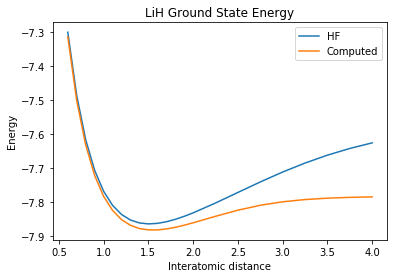

In [9]:
pylab.plot(distances, hf_energies, label='HF')
pylab.plot(distances, energies, label='Computed')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right');

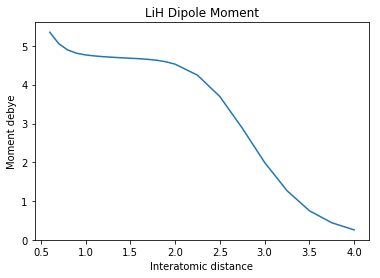

In [10]:
pylab.plot(distances, dipoles)
pylab.xlabel('Interatomic distance')
pylab.ylabel('Moment debye')
pylab.title('LiH Dipole Moment');